# [SITCOM-772] - M1M3 Actutator Bump Test Failure Analysis

Notebook containing data analysis for the [LVV-T229] and [LVV-T238] test cases. 

Scripts used to run these test cases can be found respectively in:

+ [M13T002.py] 
+ [M13T018.py]     

Note that [LVV-T229] ([M13T002.py]) can also be executed using the SAL Script `check_actuators.py`. 
The code used to run the bump test is not relevant to this analysis.


## Goal:
---

Bases on the hiphotesis that a high failure rate could indicate a problem with an actuator, 
we want to obtain a list of actuators with the highest failure rate. 
This is particular useful to keep track of trouble makers.


## Methodology
---
We will obtaint the relative rate of failures, normalizing the total number of failures to be equal to one. 
In this way, we will determine which actuators give more trouble when compared to others. 


## Results
---
Results can be found at associated technote:

+ [SITCOMTN-083: M1M3 mirror cell bump testing] 


[LVV-T229]: https://jira.lsstcorp.org/secure/Tests.jspa#/testCase/LVV-T229
[LVV-T238]: https://jira.lsstcorp.org/secure/Tests.jspa#/testCase/LVV-T238

[M13T002.py]: https://github.com/lsst-ts/ts_m1m3supporttesting/blob/develop/M13T002.py
[M13T018.py]: https://github.com/lsst-ts/ts_m1m3supporttesting/blob/develop/M13T018.py

[SITCOM-772]: https://jira.lsstcorp.org/browse/SITCOM-772

[SITCOMTN-083: M1M3 mirror cell bump testing]: https://sitcomtn-083.lsst.io/

## Preparing the Notebook
---

### Importing libraries

In [1]:
import re
import pandas as pd
import numpy as np
import logging as log
import matplotlib.pyplot as plt
from astropy.time import Time

try:
    from lsst.ts.xml.tables.m1m3 import FATable
except ImportError:
    from lsst.ts.criopy.M1M3FATable import FATABLE as FATable

from lsst_efd_client import EfdClient

%matplotlib widget
%load_ext autoreload
%autoreload 2
%load_ext lab_black

## Collecting data
---

### Setting up times


In [2]:
# Times of a specific bump test
# start = Time("2023-04-11T16:00:00.", format="isot", scale='utc')
# end = Time("2023-04-11T18:51:14", format="isot", scale='utc')

# Times for multiple bump tests over the years
start = Time("2018-10-17T10:00:00", format="isot", scale="utc")
end = Time(Time.now(), scale="utc", format="isot")

In [3]:
# Making a client to the desired database
# client = EfdClient('summit_efd')
client = EfdClient("idf_efd")  # It contains lost data

In [4]:
# Not working for 'ifd_efd' client
# schema = await client.get_schema('lsst.sal.MTM1M3.logevent_forceActuatorBumpTestStatus')
# schema

### Getting bump test data frame

In [5]:
bump = await client.select_time_series(
    "lsst.sal.MTM1M3.logevent_forceActuatorBumpTestStatus", "*", start, end
)

In [6]:
bump[bump.actuatorId != -1]

,actuatorId,primaryTest0,primaryTest1,primaryTest10,primaryTest100,primaryTest101,primaryTest102,primaryTest103,primaryTest104,primaryTest105,...,secondaryTestTimestamps91,secondaryTestTimestamps92,secondaryTestTimestamps93,secondaryTestTimestamps94,secondaryTestTimestamps95,secondaryTestTimestamps96,secondaryTestTimestamps97,secondaryTestTimestamps98,secondaryTestTimestamps99,timestamp
2022-11-07 14:58:45.057533+00:00,101,1,1,1,1,1,1,1,1,1,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2022-11-07 14:58:48.255728+00:00,101,2,1,1,1,1,1,1,1,1,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.667833e+09
2022-11-07 14:58:51.435993+00:00,101,3,1,1,1,1,1,1,1,1,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.667833e+09
2022-11-07 14:58:54.617480+00:00,101,4,1,1,1,1,1,1,1,1,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.667833e+09
2022-11-07 14:58:57.816576+00:00,101,5,1,1,1,1,1,1,1,1,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.667833e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-15 17:15:28.258125+00:00,227,6,6,6,6,6,6,6,6,6,...,1.700064e+09,1.700064e+09,1.700064e+09,1.700064e+09,1.700064e+09,1.700064e+09,1.700065e+09,1.700065e+09,1.700065e+09,1.700069e+09
2023-11-15 17:15:31.637034+00:00,227,6,6,6,6,6,6,6,6,6,...,1.700064e+09,1.700064e+09,1.700064e+09,1.700064e+09,1.700064e+09,1.700064e+09,1.700065e+09,1.700065e+09,1.700065e+09,1.700069e+09
2023-11-15 17:15:34.815871+00:00,227,6,6,6,6,6,6,6,6,6,...,1.700064e+09,1.700064e+09,1.700064e+09,1.700064e+09,1.700064e+09,1.700064e+09,1.700065e+09,1.700065e+09,1.700065e+09,1.700069e+09
2023-11-15 17:15:38.015780+00:00,227,6,6,6,6,6,6,6,6,6,...,1.700064e+09,1.700064e+09,1.700064e+09,1.700064e+09,1.700064e+09,1.700064e+09,1.700065e+09,1.700065e+09,1.700065e+09,1.700069e+09


## Helper Functions
---

Here we define a couple of helper function to interact with the FATable.

In [7]:
# Getting primary {index: id} dictionary
m1m3_actuator_index_id_table: dict[int, int] = dict(
    [(fa.index, fa.actuator_id) for fa in FATable]
)

# Getting secondary {index: id} dictionary
m1m3_actuator_sindex_id_table: dict[int, int] = dict(
    [(fa.s_index, fa.actuator_id) for fa in FATable if fa.s_index is not None]
)

# Getting primary {id: index} dictionary
m1m3_actuator_id_index_table: dict[int, int] = dict(
    [(fa.actuator_id, fa.index) for fa in FATable]
)


def get_id(index):
    if index in m1m3_actuator_index_id_table.keys():
        return m1m3_actuator_index_id_table[index]
    else:
        raise ValueError("You provides an invalid actuator id")


def get_sid(index):
    if index in m1m3_actuator_sindex_id_table.keys():
        return m1m3_actuator_sindex_id_table[index]
    else:
        raise ValueError("You provides an invalid index")


def get_m1m3_actuator_ids() -> list[int]:
    """Get a list of the M1M3 actuator ids.

    Returns
    -------
    `list`[ `int` ]
        List of M1M3 actuator ids.
    """
    return list(m1m3_actuator_id_index_table.keys())


def is_actuator_dual(actuator_id, actuator_list=FATable):
    actuator_id = int(actuator_id)

    if actuator_id not in get_m1m3_actuator_ids():
        raise ValueError(f"Invalid actuator id: {actuator_id}.")
    else:
        actuator = next(
            (act for act in actuator_list if act.actuator_id == actuator_id), None
        )

        return actuator is not None and actuator.actuator_type.name == "DAA"


def get_orientation(actuator_id, actuator_list=FATable):
    # Define the mapping
    orientation_mapping = {
        "Y_PLUS": "Y+",
        "Y_MINUS": "Y-",
        "X_PLUS": "X+",
        "X_MINUS": "X-",
        "NA": "NA",
    }

    # Check for invalid actuator_id
    if actuator_id not in get_m1m3_actuator_ids():
        raise ValueError(f"Invalid actuator id: {actuator_id}.")

    # Search for the actuator with a given actuator_id and return mapped orientation
    for actuator in actuator_list:
        if actuator.actuator_id == actuator_id:
            # Get the original orientation name and map it
            orientation = actuator.orientation.name
            return orientation_mapping.get(orientation)


def get_xy_position(actuator_list=FATable):
    # Collect all x and y positions using list comprehensions
    xpos = [actuator.x_position for actuator in actuator_list]
    ypos = [actuator.y_position for actuator in actuator_list]

    return xpos, ypos


def id_position_map(actuator_list=FATable):
    return {
        actuator.actuator_id: (actuator.x_position, actuator.y_position)
        for actuator in actuator_list
    }

### Getting status columns
---

Here we are removing unwanted columns to keep only columns of interest. At the same time, we are renaming columns starting with `primaryTest` (`secondaryTest`) to `primaryTest_Status` (`secondaryTest_Status`) to contain the status name in case of `PASSED` and `FAILED` status.

In [8]:
def filter_and_map_columns(bump):
    # Making private_rcvStamp as the index
    bump = bump.set_index("private_rcvStamp").copy()
    bump.index = pd.to_datetime(bump.index, unit="s")

    # Filtering columns
    columns_to_extract = bump.filter(
        regex="^actuatorID|^private_rcvStamp|^primaryTest(?!Timestamps)|^secondaryTest(?!Timestamps)"
    ).columns
    bump_status = bump[columns_to_extract].copy()

    for col in bump_status.columns:
        if "Test" in col:
            index = int(col.split("Test")[1].split("_")[0])

            cylinder = col.split("Test")[0]

            if cylinder == "primary":
                actuator_id = get_id(int(index))
            elif cylinder == "secondary":
                actuator_id = get_sid(int(index))

            new_col_name = f"{cylinder}Test_Status_{actuator_id}"
            bump_status.rename(columns={col: new_col_name}, inplace=True)

    # Mapping status
    status_mapping = {
        1: "NOTTESTED",
        2: "TESTINGPOSITIVE",
        3: "TESTINGPOSITIVEWAIT",
        4: "TESTINGNEGATIVE",
        5: "TESTINGNEGATIVEWAIT",
        6: "PASSED",
        7: "FAILED",
    }

    # Iterate over the columns
    for column in bump_status.columns:
        if "Status" in column:
            # Replace the column values using the status_mapping dictionary
            bump_status[column] = bump_status[column].replace(status_mapping)

    return bump_status

In [9]:
# Getting filtered bump data frame
bump_status = filter_and_map_columns(bump)

bump_status

,primaryTest_Status_101,primaryTest_Status_102,primaryTest_Status_111,primaryTest_Status_323,primaryTest_Status_324,primaryTest_Status_325,primaryTest_Status_326,primaryTest_Status_327,primaryTest_Status_328,primaryTest_Status_329,...,secondaryTest_Status_411,secondaryTest_Status_412,secondaryTest_Status_414,secondaryTest_Status_415,secondaryTest_Status_416,secondaryTest_Status_417,secondaryTest_Status_418,secondaryTest_Status_420,secondaryTest_Status_421,secondaryTest_Status_422
private_rcvStamp,,,,,,,,,,,,,,,,,,,,,
2022-11-03 14:58:10.707143680,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,...,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED
2022-11-07 13:57:05.127564032,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,...,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED
2022-11-07 14:03:19.508858368,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,...,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED
2022-11-07 14:33:37.266226944,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,...,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED
2022-11-07 14:59:22.059145728,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,...,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-17 01:23:47.311559168,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,...,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED
2023-11-17 01:47:32.899739904,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,...,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED
2023-11-17 21:27:59.460673792,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,...,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED


### Checking, filtering and sorting data frame columns
---

Here we are just checking the integrity of the bump status table, since it was modified with the `filter_and_map_columns` one step above.

In [10]:
def process_bump_data(bump_status):
    try:
        # Assert integrity of number of actuators being tested
        primary_test_count = sum(bump_status.columns.str.contains("primaryTest_Status"))
        secondary_test_count = sum(
            bump_status.columns.str.contains("secondaryTest_Status")
        )

        assert primary_test_count == 156, log.warning(
            f"Expected primary test count: 156, Actual count: {primary_test_count}"
        )
        assert secondary_test_count == 112, log.warning(
            f"Expected secondary test count: 112, Actual count: {secondary_test_count}"
        )

        # Checking for duplicated columns
        duplicate_columns = bump_status.columns[bump_status.columns.duplicated()]
        assert duplicate_columns.empty, log.warning(
            f"Duplicated columns {duplicate_columns}"
        )

        # Sorting bump data frame to show first primary status and then secondary
        primary_columns = [
            col for col in bump_status.columns if "primaryTest_Status" in col
        ]
        secondary_columns = [
            col for col in bump_status.columns if "secondaryTest_Status" in col
        ]

        sorted_columns = sorted(
            bump_status.columns,
            key=lambda col: (
                col not in primary_columns,
                col not in secondary_columns,
                col,
            ),
        )

        sorted_df_bump = bump_status[sorted_columns]

        return sorted_df_bump

    except AssertionError as e:
        log.warning(e)
        return None

In [11]:
df_bumps = process_bump_data(bump_status)

df_bumps.head()

,primaryTest_Status_101,primaryTest_Status_102,primaryTest_Status_103,primaryTest_Status_104,primaryTest_Status_105,primaryTest_Status_106,primaryTest_Status_107,primaryTest_Status_108,primaryTest_Status_109,primaryTest_Status_110,...,secondaryTest_Status_427,secondaryTest_Status_428,secondaryTest_Status_429,secondaryTest_Status_430,secondaryTest_Status_432,secondaryTest_Status_433,secondaryTest_Status_434,secondaryTest_Status_435,secondaryTest_Status_437,secondaryTest_Status_438
private_rcvStamp,,,,,,,,,,,,,,,,,,,,,
2022-11-03 14:58:10.707143680,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,...,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED
2022-11-07 13:57:05.127564032,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,...,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED
2022-11-07 14:03:19.508858368,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,...,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED
2022-11-07 14:33:37.266226944,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,...,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED
2022-11-07 14:59:22.059145728,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,...,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED,NOTTESTED


## Calculating rate of failures
---

The analysis starts here.

### A few more helper functions to run the analysis and visualition

In [12]:
def add_orientation_column(df):
    # Create an empty list to store the orientation values
    orientation = []

    # Iterate over the index values (actuator_ids) in the DataFrame
    for actuator_id in df["actuator_id"]:
        # Get the orientation using the actuator_id
        orientation_value = get_orientation(int(actuator_id))
        # Append the orientation value to the list
        orientation.append(orientation_value)

    # Add the orientation column to the DataFrame
    df["Orientation"] = orientation

    return df


def calculate_failures(df_bumps):
    # Initialize a dictionary to store the failures for each actuator ID
    failed_counts = {}

    # Iterate over the columns
    for column in df_bumps.columns:
        # Check if the column contains the pattern 'Status_' followed by a number
        if re.search(r"Status_\d+", column):
            # Extract the actuator ID from the column name
            actuator_id = re.search(r"Status_(\d+)", column).group(1)

            # Get primary failures
            primary_column = f"primaryTest_Status_{actuator_id}"
            primary_failures = (df_bumps[primary_column] == "FAILED").sum()

            # Get secondary failures
            secondary_column = f"secondaryTest_Status_{actuator_id}"
            if secondary_column in df_bumps.columns:
                secondary_failures = (df_bumps[secondary_column] == "FAILED").sum()
            else:
                secondary_failures = None

            # Calculate the total failures
            total_failures = (
                primary_failures
                if secondary_failures is None
                else primary_failures + secondary_failures
            )

            # Store the failures in the dictionary as a tuple of (primary_failures, secondary_failures, total_failures)
            failed_counts[f"{actuator_id}"] = (
                primary_failures,
                secondary_failures,
                total_failures,
            )

    # Create a new DataFrame from the dictionary of failures
    failed_counts_df = pd.DataFrame.from_dict(
        failed_counts,
        orient="index",
        columns=["PrimaryFailures", "SecondaryFailures", "TotalFailures"],
    )

    failed_counts_df = (
        failed_counts_df.reset_index().rename(columns={"index": "actuator_id"}).copy()
    )

    # Sort the DataFrame by the total failures in descending order
    sorted_failed_counts_df = failed_counts_df.sort_values(
        by="TotalFailures", ascending=False
    )

    # Add orientation column
    sorted_failed_counts_df = add_orientation_column(sorted_failed_counts_df).copy()

    # Set actuator_id as the index
    sorted_failed_counts_df = sorted_failed_counts_df.set_index("actuator_id")

    return sorted_failed_counts_df


def plot_stacked_failures(ax, df_bumps, failures_to_show=15):
    # Extract the starting and ending dates from the DataFrame
    start_date = df_bumps.index.min()
    end_date = df_bumps.index.max()

    start_date_formatted = start_date.strftime("%Y-%m-%d %H:%M:%S")
    end_date_formatted = end_date.strftime("%Y-%m-%d %H:%M:%S")

    # Passing argument
    N = failures_to_show

    # Calculate failures on the fly
    sorted_failed_counts_df = calculate_failures(df_bumps)

    # Calculate the total number of failures
    total_failures = sorted_failed_counts_df["TotalFailures"].sum()

    # Calculate the frequency of failures
    total_frequency = sorted_failed_counts_df["TotalFailures"] / total_failures
    pri_frequency = sorted_failed_counts_df["PrimaryFailures"] / total_failures
    sec_frequency = (
        sorted_failed_counts_df["SecondaryFailures"].fillna(0) / total_failures
    )

    # Create a bar plot for primary failures
    ax.bar(
        sorted_failed_counts_df.index[0:N],  # Use index here
        pri_frequency[0:N],
        label="Primary",
    )

    # Create the bar plot for secondary failures, stacked on top of primary failures
    ax.bar(
        sorted_failed_counts_df.index[0:N],  # And here
        sec_frequency[0:N],
        bottom=pri_frequency[0:N],
        label="Secondary",
    )

    # Set the title and labels
    plt.suptitle(
        f"Starting Date: {start_date_formatted}   Final Date: {end_date_formatted}"
    )
    ax.set_title("Frequency of Failures by Actuator ID")
    ax.set_xlabel("Actuator ID")
    ax.set_ylabel("Frequency")
    ax.legend(loc="best")

    ax.set_ylim(0, total_frequency.max() + 0.05)

    # Rotating X-axis labels
    for tick in ax.get_xticklabels():
        tick.set_rotation(45)

    # Display the orientation information as text
    for actuator_id, row in sorted_failed_counts_df[0:N].iterrows():
        orientation = row["Orientation"]
        if is_actuator_dual(actuator_id):
            if row["SecondaryFailures"] > 0:
                ax.text(
                    actuator_id,
                    total_frequency[actuator_id],
                    f"{orientation}",
                    ha="center",
                    va="bottom",
                    fontsize=8,
                    color="orange",
                )

    return


def ActuatorsLayout(ax, failures_df, actuator_list=FATable):
    """From Craig's code"""

    failed_actuators = [int(i) for i in list(failures_df.index)]

    ax.set_xlabel("X position (m)")
    ax.set_ylabel("Y position (m)")
    ax.set_title("M1M3 Failed Actuators", fontsize=12)

    ids = get_m1m3_actuator_ids()
    xpos, ypos = get_xy_position()

    # Circles
    ax.plot(xpos, ypos, "o", ms=14, color="blue", alpha=0.05, mec="red")

    for l, x, y in zip(ids, xpos, ypos):
        ax.annotate(
            l,
            (x, y),
            textcoords="offset points",
            xytext=(-5.5, -2),
            color="blue",
            size="xx-small",
        )

    # Flag failed actuators with red bold circle
    if failed_actuators:
        for actuator_id in failed_actuators:
            if actuator_id in ids:
                index = ids.index(actuator_id)
                ax.scatter(
                    xpos[index],
                    ypos[index],
                    marker="o",
                    facecolors="none",
                    edgecolors="red",
                    s=250,
                    alpha=0.5,
                    linewidths=2,
                )

    Rhp = 3.1  # Radius in meters
    for i in range(6):
        theta = 2.0 * np.pi / 6.0 * float(i)
        if i == 0:
            ax.scatter(
                Rhp * np.cos(theta),
                Rhp * np.sin(theta),
                marker="*",
                color="green",
                s=30,
                alpha=0.3,
            )
        else:
            ax.scatter(
                Rhp * np.cos(theta),
                Rhp * np.sin(theta),
                marker="*",
                color="green",
                s=30,
                alpha=0.3,
            )
    return


def find_failed_cells(df_bumps):
    unique_failed_cells = set()
    df = df_bumps.copy()
    # Filter for columns starting with specific names
    columns_of_interest = [
        col
        for col in df.columns
        if col.startswith("secondaryTest_Status_")
        or col.startswith("primaryTest_Status_")
    ]

    for col in columns_of_interest:
        if df[col].apply(lambda x: "FAILED" in str(x)).any():
            # Find the first occurrence of "FAILED" in the column
            failed_row = df[col][df[col].apply(lambda x: "FAILED" in str(x))].index[0]
            unique_failed_cells.add((failed_row, col))

    return unique_failed_cells


# Find and print the first occurrence of "FAILED" in each column
# failed_cells = find_failed_cells(df_bumps)
# for index, col in failed_cells:
#    print(f"Failed '{col}'  Time Stamp: {index}")

### Generating Histogram with failures

Note that every actuator has a Z-axis, so we only show the orientatino of a given failure for dual axis actuator.

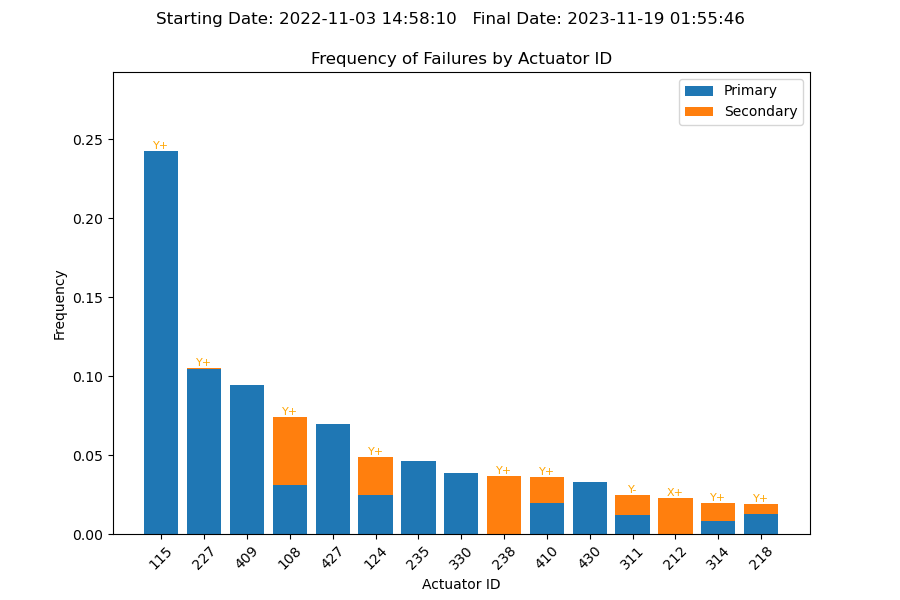

In [13]:
fig, ax = plt.subplots(figsize=(9, 6))

plot_stacked_failures(ax, df_bumps, failures_to_show=15)

### Displaying Actuators Layout Highlingting Failures


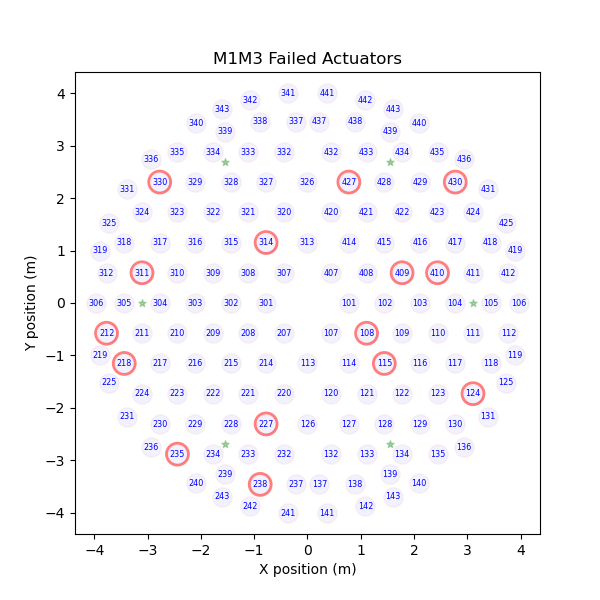

In [14]:
# Create the figure and axes
fig, ax = plt.subplots(figsize=(6, 6))

# Getting sorted failures data frame
failures_df = calculate_failures(df_bumps)

# List of failed actuator IDs
failures_df = failures_df[0:15]

# Call the function to plot the actuators and flag the failed ones
ActuatorsLayout(ax, failures_df, actuator_list=FATable)

### Histogram + Layout

Same result as above, but putting both together with subplots.

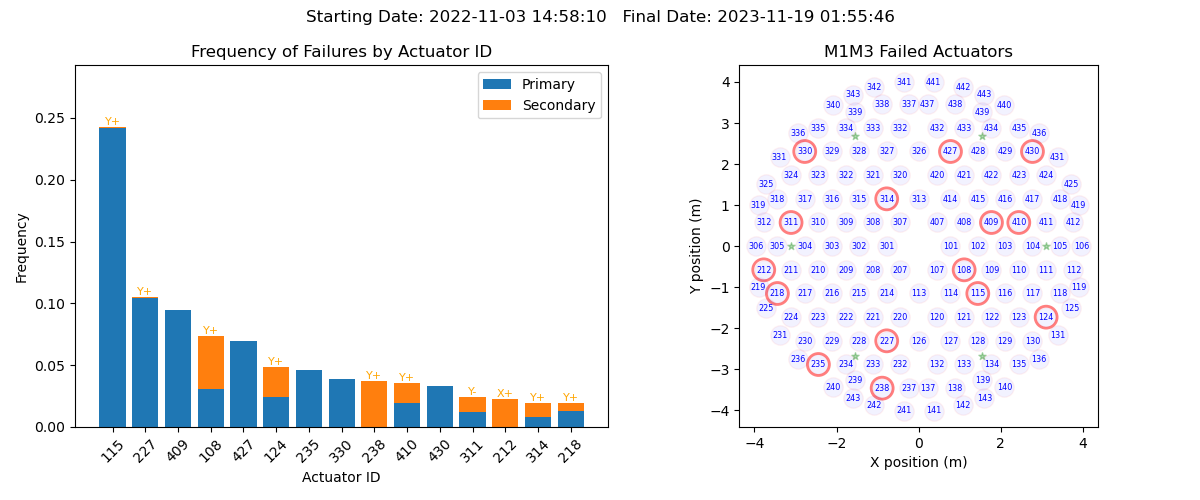

In [19]:
# Number of actuator with the highest falures to be shown
failures_to_show = 15

# Create the figure and axes
fig, [ax0, ax1] = plt.subplots(1, 2, figsize=(12, 5))

# Histogram aspect should be automatic
ax0.set_aspect("auto", adjustable="box")

# Layout figre aspect needs to be rectangular
ax1.set_aspect("equal", adjustable="box")

# List of failed actuator IDs
failures_df = failures_df[0:failures_to_show]

# Call the function to plot the actuators and flag the failed ones
plot_stacked_failures(ax0, df_bumps, failures_to_show=failures_to_show)

# Call the function to plot the actuators and flag the failed ones
ActuatorsLayout(ax1, failures_df, actuator_list=FATable)

# Show the plot
plt.tight_layout()
# plt.savefig("histogram_frequency_of_failures.png", dpi=300)

## 3D Failures Rate Distribution
---

Here we want to create a 3d visualization of the failures

### Helper Functions

In [16]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


def remove_zpanel(ax):
    # Remove the z-axis panes, grids and lines
    alpha = 0
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, alpha))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, alpha))
    #
    ax.zaxis._axinfo["grid"]["color"] = (1.0, 1.0, 1.0, alpha)
    ax.yaxis._axinfo["grid"]["linewidth"] = 0
    ax.xaxis._axinfo["grid"]["linewidth"] = 0
    #
    ax.zaxis.line.set_lw(0.0)
    ax.set_zticks([])
    #
    ax.set_zlabel("")  # remove z-axis label 'z'


def create_3d_heatmap(
    ax, df_bumps, failures_df, actuator_list=FATable, failures_to_show=15
):
    # Failed actuators list
    failed_actuators = [int(i) for i in list(failures_df.index)]

    # Calculate failures
    sorted_failed_counts_df = calculate_failures(df_bumps)
    N = min(failures_to_show, len(sorted_failed_counts_df))

    xpos, ypos = get_xy_position(actuator_list)
    total_failures = sorted_failed_counts_df["TotalFailures"].sum()
    pri_frequency = sorted_failed_counts_df["PrimaryFailures"] / total_failures
    sec_frequency = (
        sorted_failed_counts_df["SecondaryFailures"].fillna(0) / total_failures
    )

    # Calculate the radius of the cylinders based on the circle area
    circle_area = 0.3  # Modify this value to adjust the cylinder size
    circle_radius = np.sqrt(circle_area / np.pi)

    ids = get_m1m3_actuator_ids()
    xpos, ypos = get_xy_position(actuator_list)

    table_xy_pos = id_position_map(actuator_list)

    # Create the 3D bar plot for primary failures
    for i in range(N):
        actuator_id = sorted_failed_counts_df.index[i]
        x = table_xy_pos[int(actuator_id)][0]
        y = table_xy_pos[int(actuator_id)][1]
        z = pri_frequency.loc[actuator_id]

        ax.bar3d(
            x - 0.15,
            y - 0.15,
            0,
            circle_radius,
            circle_radius,
            z,
            shade=True,
            color="blue",
        )

    # Create the 3D bar plot for secondary failures, stacked on top of primary failures
    for i in range(N):
        actuator_id = sorted_failed_counts_df.index[i]
        x = table_xy_pos[int(actuator_id)][0]
        y = table_xy_pos[int(actuator_id)][1]
        z_bottom = pri_frequency.loc[actuator_id]
        z = sec_frequency.loc[actuator_id]

        ax.bar3d(
            x - 0.15,
            y - 0.15,
            z_bottom,
            circle_radius,
            circle_radius,
            z,
            shade=True,
            color="orange",
            label="Secondary",
        )

        ax.text(
            x,
            y,
            z + z_bottom + 0.01,
            str(actuator_id),
            color="black",
            ha="center",
            va="center",
            fontsize="xx-small",
        )

        ax.view_init(elev=20.0, azim=218)

    # Plot the actuators layout
    ActuatorsLayout(ax, failures_df, actuator_list=FATable)

    # Uncomment to remove z-panel from 3d plot.
    # remove_zpanel(ax)

    # Circles
    ax.plot(xpos, ypos, "o", ms=14, color="blue", alpha=0.05, mec="red")

    for l, x, y in zip(ids, xpos, ypos):
        z = 0
        ax.text(
            x,
            y,
            z,
            str(l),
            color="black",
            ha="center",
            va="center",
            fontsize="xx-small",
        )

    return ax

### 3D Results

Here we effectively show the failures.

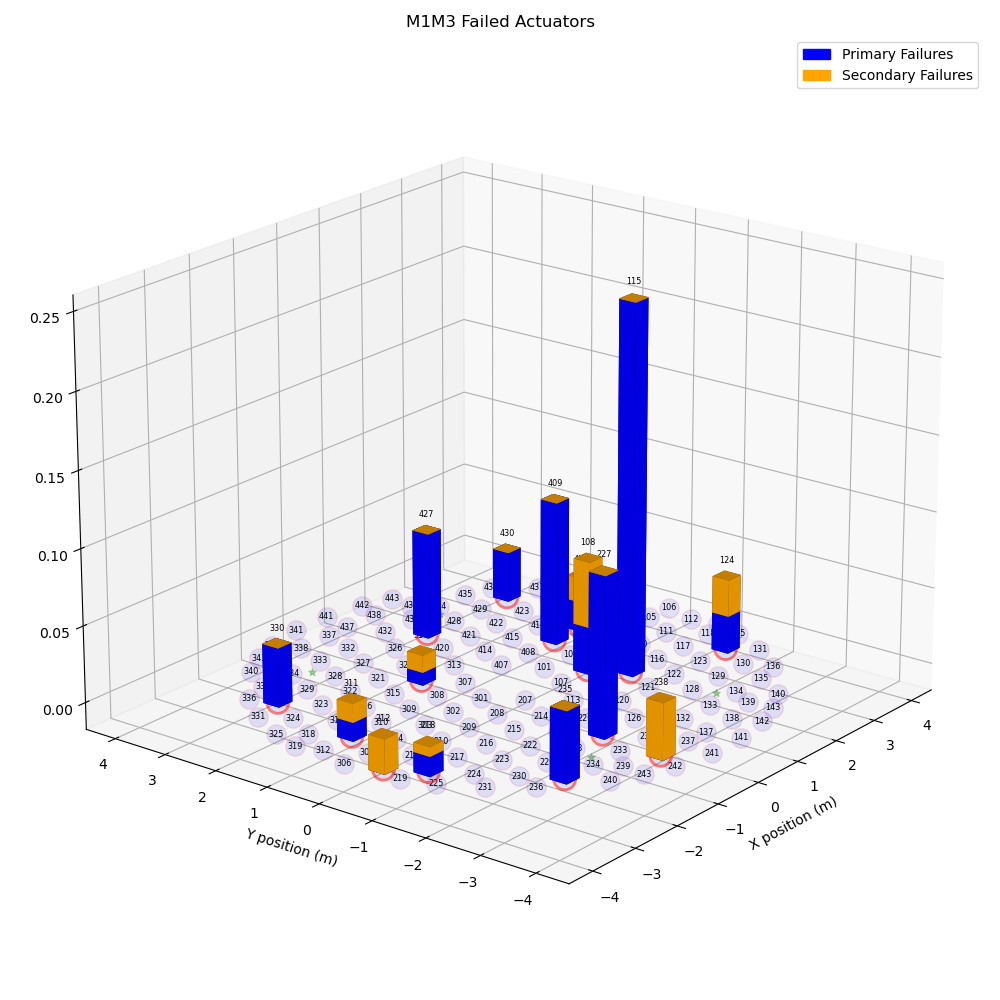

In [20]:
from matplotlib.patches import Patch

# Create the figure and 3D Axes
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax_legend = fig.add_subplot(122)  # Legend subplot

# Getting sorted failures data frame
sorted_failed_counts_df = calculate_failures(df_bumps)

# Total number of failed actuators to be shown
failures_to_show = 15

# Sliced data frame
sorted_failed_df = sorted_failed_counts_df[0:failures_to_show]

# Call the combined function to plot the 3D heatmap
create_3d_heatmap(ax, df_bumps, sorted_failed_df, actuator_list=FATable)


# Create a custom legend for the legend subplot
legend_patches = [
    Patch(color="blue", label="Primary Failures"),
    Patch(color="orange", label="Secondary Failures"),
]

ax_legend.legend(handles=legend_patches, loc="best")
ax_legend.axis("off")  # Turn off the axes for the legend subplot

plt.tight_layout()

# Save fig
# plt.savefig("layout_frequency_of_failures.png")